# Time series analysis with ARIMA
Some time ago I had a discussion about time series analysis and ARIMA models, which found me quite unprepared!
So I decided to look a bit closer to this neat piece of classical time series analysis. I found out that there are several excellent tutorials on how to use ARIMA, which I link below. Still, I found it useful to compile my own example to summarize my understanding of the problem and to collect links to useful resources.

## Import libraries and get sample data

In [1]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

Get the classic international airline passengers data, downloadable from the DataMarket webpage (https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line) as a CSV with filename "international-airline-passengers.csv".

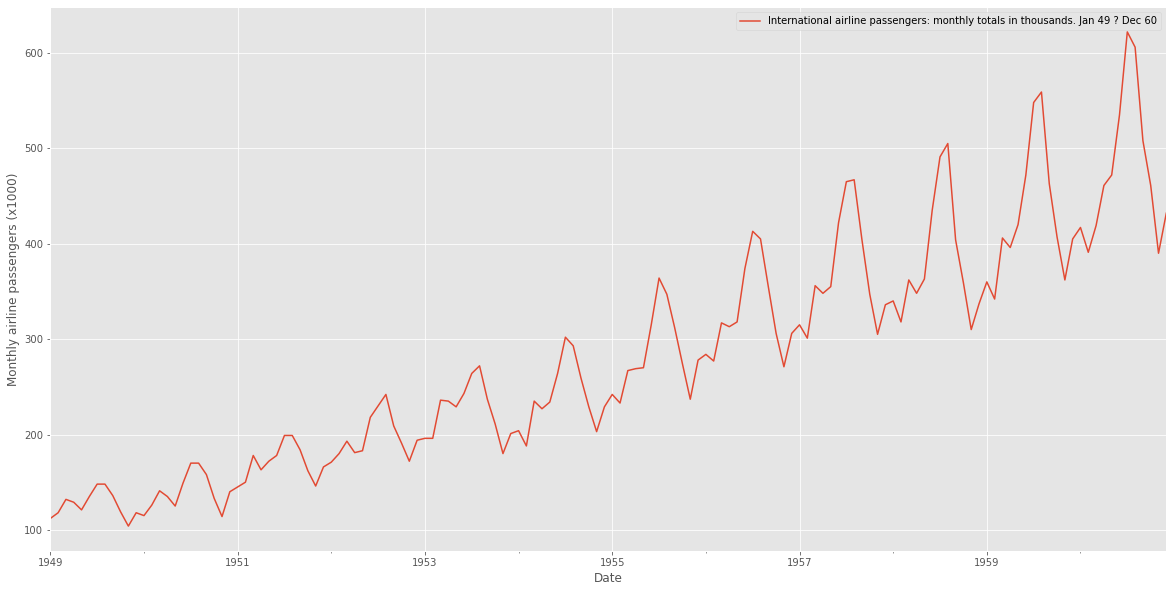

In [2]:
# Load the data
data = pd.read_csv('international-airline-passengers.csv', engine='python', skipfooter=3)
# A bit of pre-processing to make it nicer
data['Month']=pd.to_datetime(data['Month'], format='%Y-%m-%d')
data.set_index(['Month'], inplace=True)

# Plot the data
data.plot()
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.show()

Two obvious patterns appear in the data, an overall increase in the number of passengers over time, and a 12 months seasonality with peaks corresponding to the northern emisphere summer period.

## ARIMA
ARIMA stands for Auto-Regressive Integrated Moving Average. There are three  integers (p, d, q) that are used to parametrize ARIMA models. Because of that, a nonseasonal ARIMA model is denoted with ARIMA(p, d, q): 
<ul>
<li><strong>p</strong> is the number of autoregressive terms (AR part). It allows to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.</li>
<li><strong>d</strong> is the number of nonseasonal differences needed for stationarity. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.</li>
<li><strong>q</strong> is the number of lagged forecast errors in the prediction equation (MA part). This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.</li>
</ul>

When dealing with seasonal effects, as in our example, seasonal ARIMA is used, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the nonseasonal parameters described above, (<strong>P, D, Q</strong>) follow the same definition but are applied to the seasonal component of the time series. The term <strong>s</strong> is the periodicity of the time series.

While in this case it is clear that s=12, how do we set the other parameters? 

It is pretty much based on experience. There are numerous best practices that can be followed to identify ARIMA models, such as: 
http://people.duke.edu/~rnau/arimrule.htm.

Here we use grid search over all possible combinations of parameter values within a predefined range of values (heavily inspired by https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3). 

$statsmodels.tsa.statespace.sarimax.SARIMAXResults$ returns values for AIC (Akaike Information Criterion) and BIC (Bayes Information Criterion) that can be minimized to select the best fitting model. We use the AIC value, which estimates the information lost when a given model is used to represent the process that generates the data. In doing so, it deals with the trade-off between the goodness of fit of the model and the complexity of the model itself.

In [3]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


We select a subset of the data series as training data, say the first 11 years. Our goal is to predict the last year of the series based on this input.

In [4]:
train_data = data['1949-01-01':'1959-12-01']
test_data = data['1960-01-01':'1960-12-01']

In [5]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.01466D+00    |proj g|=  2.25681D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      2      1     0     0   2.206D-06   7.015D+00
  F =   7.0146482280460800     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.2

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.95319D+00    |proj g|=  3.49030D-02

At iterate   10    f=  3.92187D+00    |proj g|=  7.83166D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     16      1     0     0   3.357D-06   3.922D+00
  F =   3.9218502320874022     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:1039.3684612710742

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84134D+00    |proj g|=  1.15153D-03

           * * *

Tit   = total number 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.50812D+00    |proj g|=  3.00454D-01

At iterate   20    f=  3.50287D+00    |proj g|=  1.22599D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     23      1     0     0   1.226D-05   3.503D+00
  F =   3.5028657683556164     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:930.7565628458827

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48249D+00    |proj g|=  1.05721D-03

           * * *

Tit   = total number o

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  3.46658D+00    |proj g|=  1.63856D+00

At iterate   25    f=  3.46443D+00    |proj g|=  5.69929D-01

At iterate   30    f=  3.46426D+00    |proj g|=  1.25605D-02

At iterate   35    f=  3.46373D+00    |proj g|=  4.15845D-01

At iterate   40    f=  3.45594D+00    |proj g|=  5.52578D-01

At iterate   45    f=  3.45345D+00    |proj g|=  2.47811D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     47     69      1     0     0   4.830D-03   3.453D+00
  F =   3.4534454342283265     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:919.7095946362


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21929D+00    |proj g|=  1.97680D-01

At iterate    5    f=  3.17135D+00    |proj g|=  3.18113D-01

At iterate   10    f=  3.16116D+00    |proj g|=  6.08245D-02

At iterate   15    f=  3.11289D+00    |proj g|=  8.21241D-02

At iterate   20    f=  3.11256D+00    |proj g|=  1.10055D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     27      1     0     0   3.037D-05   3.113D+00
  F =   3.1125636834493449     

CONVERG

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08427D+00    |proj g|=  5.85480D-02

At iterate    5    f=  3.07741D+00    |proj g|=  6.36794D-02

At iterate   10    f=  3.07044D+00    |proj g|=  1.65698D+00

At iterate   15    f=  3.06219D+00    |proj g|=  1.99242D-02

At iterate   20    f=  3.06002D+00    |proj g|=  1.80118D-02

At iterate   25    f=  3.06001D+00    |proj g|=  8.25234D-02

At iterate   30    f=  3.05902D+00    |proj g|=  1.03724D+00

At iterate   35    f=  3.05693D+00    |proj g|=  4.45911D-02

At iterate   40    f=  3.05643D+00    |proj g|=  1.44519D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   45    f=  3.05627D+00    |proj g|=  1.06704D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     66      1     0     0   1.067D-02   3.056D+00
  F =   3.0562695680828780     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:816.8551659738798

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83904D+00    |proj g|=  9.31655D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnin

 This problem is unconstrained.



At iterate    5    f=  2.77951D+00    |proj g|=  1.27003D-01

At iterate   10    f=  2.77047D+00    |proj g|=  6.51289D-02

At iterate   15    f=  2.76711D+00    |proj g|=  1.66902D-02

At iterate   20    f=  2.74576D+00    |proj g|=  2.23983D-01

At iterate   25    f=  2.73132D+00    |proj g|=  3.09968D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     35      1     0     0   3.766D-05   2.731D+00
  F =   2.7313227573631766     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:731.0692079438786

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.04545D+00    |proj g|=  9.50733D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     22      1     0     0   1.341D-06   4.045D+00
  F =   4.0454046816653682     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.78274D+00    |proj g|=  2.54736D-01

At iterate    5    f=  3.72390D+00    |proj g|=  4.53609D-02

At iterate   10    f=  3.59701D+00    |proj g|=  4.92216D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.84615D+00    |proj g|=  1.61329D+00

At iterate   20    f=  3.62574D+00    |proj g|=  1.98735D-01

At iterate   25    f=  3.62421D+00    |proj g|=  3.78577D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     53      1     0     0   3.236D-07   3.624D+00
  F =   3.6242077386845417     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.03280D+00    |proj g|=  7.33049D-01

At iter

 This problem is unconstrained.



At iterate   35    f=  3.53782D+00    |proj g|=  3.09184D-02

At iterate   40    f=  3.53778D+00    |proj g|=  8.40527D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     43     70      1     0     0   7.811D-05   3.538D+00
  F =   3.5377825804195719     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.78226D+00    |proj g|=  1.41840D-01

At iterate    5    f=  3.76426D+00    |proj g|=  4.50413D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.67284D+00    |proj g|=  2.09063D-02

At iterate   10    f=  3.49062D+00    |proj g|=  5.68085D-01

At iterate   15    f=  3.29431D+00    |proj g|=  7.87886D-02

At iterate   20    f=  3.29128D+00    |proj g|=  4.97531D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     26      1     0     0   4.975D-06   3.291D+00
  F =   3.2912789667686848     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  5.37369D+00    |proj g|=  4.76443D-02

At iterate   10    f=  5.16897D+00    |proj g|=  6.05054D-01

At iterate   15    f=  4.43469D+00    |proj g|=  8.01205D-01

At iterate   20    f=  3.89365D+00    |proj g|=  1.68050D+00

At iterate   25    f=  3.67135D+00    |proj g|=  2.88324D-01

At iterate   30    f=  3.32759D+00    |proj g|=  5.16131D-01

At iterate   35    f=  3.27961D+00    |proj g|=  1.20087D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     65      1     0     0   1.591D-04   3.280D+00
  F =   3.2796055011720879     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   20    f=  4.50837D+00    |proj g|=  8.83118D-02

At iterate   25    f=  4.12251D+00    |proj g|=  4.01466D+00

At iterate   30    f=  3.49507D+00    |proj g|=  1.51090D+00

At iterate   35    f=  3.26120D+00    |proj g|=  4.45215D-01

At iterate   40    f=  3.25230D+00    |proj g|=  1.60294D+00

At iterate   45    f=  3.25078D+00    |proj g|=  1.89274D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49    110      2     0     0   2.986D-04   3.251D+00
  F =   3.2507729864758352     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:868.2040684296205

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33433D+00    |proj g|=  1.12059D-01

At iterate    5    f=  3.31818D+00    |proj g|=  5.38890D-02

At iterate   10    f=  3.10282D+00    |proj g|=  1.16730D-01

At iterate   15    f=  3.07037D+00    |p

 This problem is unconstrained.



At iterate   10    f=  3.26571D+00    |proj g|=  7.25847D-02

At iterate   15    f=  3.00343D+00    |proj g|=  7.66439D-01

At iterate   20    f=  2.97117D+00    |proj g|=  1.30799D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     38      1     0     0   5.803D-05   2.971D+00
  F =   2.9711569340248603     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.90665D+00    |proj g|=  5.96002D-01

At iterate    5    f=  4.77857D+00    |proj g|=  2.29273D-02

At iterate   10    f=  4.75588D+00    |proj g|=  1.79673D-01

At iterate   15    f=  4.53904D+00    |proj g|=  1.49965D-01

At iterate   20    f=  4.21257D+00    |proj g|=  1.64246D+00

At iterate   25    f=  3.02267D+00    |proj g|=  1.52523D+00

At iterate   30    f=  2.91181D+00    |proj g|=  4.41721D-01

At iterate   35    f=  2.90088D+00    |proj g|=  2.26260D-02

At iterate   40    f=  2.89999D+00    |proj g|=  4.58268D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  4.77912D+00    |proj g|=  3.69381D-03

At iterate   10    f=  4.76272D+00    |proj g|=  7.29964D-02

At iterate   15    f=  4.73058D+00    |proj g|=  4.75134D-02

At iterate   20    f=  4.40977D+00    |proj g|=  1.56456D+00

At iterate   25    f=  3.62925D+00    |proj g|=  3.43689D-01

At iterate   30    f=  3.10803D+00    |proj g|=  1.60803D+00

At iterate   35    f=  2.91798D+00    |proj g|=  4.70239D-01

At iterate   40    f=  2.89538D+00    |proj g|=  8.00640D-02

At iterate   45    f=  2.88524D+00    |proj g|=  5.72363D-01

At iterate   50    f=  2.87925D+00    |proj g|=  1.94874D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.89613D+00    |proj g|=  4.66286D-02

At iterate   10    f=  2.67088D+00    |proj g|=  1.43832D-01

At iterate   15    f=  2.66174D+00    |proj g|=  8.58193D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     22      1     0     0   9.292D-06   2.662D+00
  F =   2.6617371884525363     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:712.6986177514696

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90657D+00    |p

 This problem is unconstrained.



At iterate    5    f=  2.89459D+00    |proj g|=  3.97119D-02

At iterate   10    f=  2.81636D+00    |proj g|=  8.95841D-02

At iterate   15    f=  2.60368D+00    |proj g|=  1.54768D-01

At iterate   20    f=  2.58468D+00    |proj g|=  5.33797D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     33      1     0     0   2.676D-05   2.584D+00
  F =   2.5843028956992629     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:694.2559644646054

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are e

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after 20 function
  and gradient evaluations.  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 12) - AIC:1267.4912483529856

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.22135D+00    |proj g|=  2.24580D-01

At iterate    5    f=  4.19368D+00    |proj g|=  6.30136D-02

At iterate   10    f=  4.03688D+00    |proj g|=  1.17916D-01

At iterate   15    f=  4.02462D+00    |proj g|=  7.63289D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     23      1     0     0   6.263D-06   4.025D+00
  F =   4.0246217392343757     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.05336D+00    |proj g|=  3.34321D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     10      1     0     0   3.321D-05   3.053D+00
  F =   3.0533565510434917     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.0

 This problem is unconstrained.



At iterate   20    f=  3.04424D+00    |proj g|=  1.30096D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   4.993D-06   3.044D+00
  F =   3.0442428135706696     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76398D+00    |proj g|=  3.33698D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.75549D+00    |proj g|=  8.13483D-02

At iterate   10    f=  2.75093D+00    |proj g|=  3.84471D-03

At iterate   15    f=  2.75025D+00    |proj g|=  4.48003D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     25      1     0     0   1.305D-06   2.750D+00
  F =   2.7502395471927774     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:734.0632404588932

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70843D+00    |p

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.70997D+00    |proj g|=  4.25756D-02

At iterate   10    f=  2.70966D+00    |proj g|=  1.16751D-03

At iterate   15    f=  2.70964D+00    |proj g|=  1.64589D-02

At iterate   20    f=  2.70556D+00    |proj g|=  6.87483D-02

At iterate   25    f=  2.70476D+00    |proj g|=  1.83320D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     35      1     0     0   2.393D-07   2.705D+00
  F =   2.7047574537860477     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:724.0559677995166

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.41204D+00    |proj g|=  3.17040D-03

At iterate   10    f=  2.41178D+00    |proj g|=  7.94413D-03

At iterate   15    f=  2.41178D+00    |proj g|=  5.09994D-03

At iterate   20    f=  2.41178D+00    |proj g|=  2.19954D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     38      1     0     0   2.200D-04   2.412D+00
  F =   2.4117781993300933     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:646.7094446231446

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are e


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.97386D+00    |proj g|=  3.65692D-02

At iterate   15    f=  3.96941D+00    |proj g|=  5.59880D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     19      1     0     0   2.517D-06   3.969D+00
  F =   3.9694121940045322     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34599D+00    |proj g|=  8.02186D-03

At iterate    5    f=  3.34582D+00    |proj g|=  3.57240D-03

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.35942D+00    |proj g|=  1.69202D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     24      1     0     0   3.589D-06   3.359D+00
  F =   3.3594221231066150     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91508D+00    |proj g|=  8.77946D-02

At iterate    5    f=  3.80382D+00    |proj g|=  3.23234D-01

At iterate   10    f=  3.27793D+00    |proj g|=  1.21643D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07539D+00    |proj g|=  2.22329D-02

At iterate    5    f=  3.07498D+00    |proj g|=  4.42633D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   3.405D-06   3.075D+00
  F =   3.0749749697467617     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:817.7933920131451

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exa

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.53506D+00    |proj g|=  7.35373D-02

At iterate   10    f=  3.24245D+00    |proj g|=  2.46271D-01

At iterate   15    f=  3.02360D+00    |proj g|=  4.83798D-02

At iterate   20    f=  3.01124D+00    |proj g|=  1.52749D-02

At iterate   25    f=  3.00721D+00    |proj g|=  8.27814D-03

At iterate   30    f=  3.00470D+00    |proj g|=  2.31618D-02

At iterate   35    f=  3.00276D+00    |proj g|=  1.49508D-02

At iterate   40    f=  3.00162D+00    |proj g|=  1.85105D-02

At iterate   45    f=  3.00081D+00    |proj g|=  1.79407D-02

At iterate   50    f=  2.99980D+00    |proj g|=  3.36097D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   1.616D-06   2.745D+00
  F =   2.7446712724456921     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75793D+00    |proj g|=  7.97059D-02


 This problem is unconstrained.



At iterate    5    f=  2.74127D+00    |proj g|=  5.01576D-02

At iterate   10    f=  2.73562D+00    |proj g|=  7.82212D-03

At iterate   15    f=  2.73478D+00    |proj g|=  2.69290D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     28      1     0     0   4.336D-07   2.735D+00
  F =   2.7347729557591096     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:731.980060320405

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17630D+00    |pr

 This problem is unconstrained.



At iterate    5    f=  3.14647D+00    |proj g|=  3.03113D-02

At iterate   10    f=  2.95353D+00    |proj g|=  1.10795D-01

At iterate   15    f=  2.69386D+00    |proj g|=  1.12822D-01

At iterate   20    f=  2.66930D+00    |proj g|=  3.98583D-03

At iterate   25    f=  2.66927D+00    |proj g|=  5.84293D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     0     0   5.843D-06   2.669D+00
  F =   2.6692698058765778     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:714.6872287514166

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.


At iterate    5    f=  3.15203D+00    |proj g|=  3.14358D-02

At iterate   10    f=  3.05620D+00    |proj g|=  1.47162D-01

At iterate   15    f=  2.73319D+00    |proj g|=  2.65154D-01

At iterate   20    f=  2.67445D+00    |proj g|=  1.27406D-02

At iterate   25    f=  2.67114D+00    |proj g|=  1.00892D-02

At iterate   30    f=  2.66972D+00    |proj g|=  2.22407D-02

At iterate   35    f=  2.66941D+00    |proj g|=  8.47187D-03

At iterate   40    f=  2.66930D+00    |proj g|=  8.80903D-04

At iterate   45    f=  2.66926D+00    |proj g|=  8.31848D-04

At iterate   50    f=  2.66924D+00    |proj g|=  1.30742D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   8.662D-06   2.400D+00
  F =   2.3996722484026898     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41522D+00    |proj g|=  8.53825D-02


 This problem is unconstrained.



At iterate    5    f=  2.40064D+00    |proj g|=  7.33667D-03

At iterate   10    f=  2.39301D+00    |proj g|=  7.16617D-02

At iterate   15    f=  2.38911D+00    |proj g|=  6.94111D-03

At iterate   20    f=  2.38843D+00    |proj g|=  2.27287D-02

At iterate   25    f=  2.38426D+00    |proj g|=  7.44203D-02

At iterate   30    f=  2.38419D+00    |proj g|=  6.43381D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     52      1     0     0   1.585D-04   2.384D+00
  F =   2.3841933872421883     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.82669D+00    |proj g|=  4.02109D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   4.020D-04   4.827D+00
  F =   4.8266888045032292     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.1

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.09393D+00    |proj g|=  3.00829D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     14      1     0     0   6.338D-06   3.094D+00
  F =   3.0937873310936723     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.98526D+00    |proj g|=  4.87705D-02

At iterate    5    f=  3.97327D+00    |proj g|=  3.39870D-02

At iterate   10    f=  3.73224D+00    |proj g|=  2.22247D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.34259D+00    |proj g|=  4.62397D-01

At iterate   25    f=  3.30462D+00    |proj g|=  7.41197D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     49      1     0     0   5.091D-06   3.304D+00
  F =   3.3039129357621135     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43514D+00    |proj g|=  7.18142D-01

At iterate    5    f=  3.09431D+00    |proj g|=  1.48305D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.12063D+00    |proj g|=  5.56837D-02

At iterate   20    f=  3.11866D+00    |proj g|=  7.94227D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   3.468D-06   3.119D+00
  F =   3.1186250161707090     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58356D+00    |proj g|=  4.55667D-02

At iterate    5    f=  3.57402D+00    |proj g|=  2.41931D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.06332D+00    |proj g|=  4.11907D-01

At iterate   25    f=  3.01554D+00    |proj g|=  2.76238D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     40      1     0     0   6.241D-06   3.015D+00
  F =   3.0154954125031974     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:804.0907889008441

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58329D+00    |proj g|=  4.52064D-02

At iterate    5    f=  3.57446D+00    |p

 This problem is unconstrained.



At iterate    5    f=  2.76146D+00    |proj g|=  2.20192D-02

At iterate   10    f=  2.76026D+00    |proj g|=  1.20219D-02

At iterate   15    f=  2.75978D+00    |proj g|=  3.79383D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     19      1     0     0   2.438D-06   2.760D+00
  F =   2.7597784152732037     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85609D+00    |proj g|=  3.66047D-01

At iterate    5    f=  2.77634D+00    |proj g|=  3.42502D-02

At iterate   10    f=  2.76594D+00    |proj g|=  1.49400D-01

At iterate   15    f=  2.74721D+00    |proj g|=  1.46917D-02

At iterate   20    f=  2.74709D+00    |proj g|=  1.11709D-02

At iterate   25    f=  2.74667D+00    |proj g|=  2.74447D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     34      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18214D+00    |proj g|=  4.07152D-02

At iterate    5    f=  3.17353D+00    |proj g|=  5.26382D-02

At iterate   10    f=  3.13528D+00    |proj g|=  1.75420D-01

At iterate   15    f=  3.03109D+00    |proj g|=  2.49931D-01

At iterate   20    f=  2.80037D+00    |proj g|=  1.83287D-01

At iterate   25    f=  2.67544D+00    |proj g|=  2.70405D-02

At iterate   30    f=  2.67446D+00    |proj g|=  1.22116D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  3.17151D+00    |proj g|=  6.18236D-02

At iterate   10    f=  3.11188D+00    |proj g|=  2.77122D-01

At iterate   15    f=  2.92321D+00    |proj g|=  3.78373D-01

At iterate   20    f=  2.71924D+00    |proj g|=  2.16548D-01

At iterate   25    f=  2.67447D+00    |proj g|=  5.57316D-02

At iterate   30    f=  2.67352D+00    |proj g|=  1.24309D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     45      1     0     0   1.217D-05   2.674D+00
  F =   2.6735194724217215     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:717.8091407193

 This problem is unconstrained.



At iterate    5    f=  2.40996D+00    |proj g|=  1.74425D-02

At iterate   10    f=  2.40914D+00    |proj g|=  7.78055D-03

At iterate   15    f=  2.40865D+00    |proj g|=  4.62610D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   6.910D-06   2.409D+00
  F =   2.4086483993951351     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47399D+00    |proj g|=  2.84364D-01

At iterate    5    f=  2.41196D+00    |proj g|=  3.42254D-02

At iterate   10    f=  2.40094D+00    |proj g|=  3.58570D-02

At iterate   15    f=  2.40039D+00    |proj g|=  1.50662D-03

At iterate   20    f=  2.40036D+00    |proj g|=  7.71474D-03

At iterate   25    f=  2.40034D+00    |proj g|=  1.64012D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     32      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  3.04912D+00    |proj g|=  5.16779D-03

At iterate   10    f=  3.04897D+00    |proj g|=  3.34478D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   3.338D-06   3.049D+00
  F =   3.0489694796066655     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.97247D+00    |proj g|=  1.35216D-01

At iterate    5    f=  3.93357D+00    |proj g|=  3.41820D-02

At itera

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.43808D+00    |proj g|=  2.36894D+00

At iterate   20    f=  3.25322D+00    |proj g|=  1.49679D-01

At iterate   25    f=  3.24953D+00    |proj g|=  7.49254D-03

At iterate   30    f=  3.24916D+00    |proj g|=  2.04256D-02

At iterate   35    f=  3.24909D+00    |proj g|=  6.46431D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     56      1     0     0   2.282D-05   3.249D+00
  F =   3.2490850208127200     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.07367D+00    |proj g|=  6.62214D-03

At iterate   20    f=  3.07365D+00    |proj g|=  6.68239D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     23      1     0     0   6.682D-06   3.074D+00
  F =   3.0736542216228653     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:819.4447145084364

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08101D+00    |proj g|=  2.22200D-01

At iterate    5    f=  3.07042D+00    |p

 This problem is unconstrained.



At iterate   10    f=  3.46882D+00    |proj g|=  2.63107D-01

At iterate   15    f=  3.40665D+00    |proj g|=  2.23311D-01

At iterate   20    f=  3.12755D+00    |proj g|=  4.94331D-01

At iterate   25    f=  3.01756D+00    |proj g|=  4.09865D-01

At iterate   30    f=  2.98127D+00    |proj g|=  1.98501D-02

At iterate   35    f=  2.98126D+00    |proj g|=  5.13295D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     52      1     0     0   1.487D-05   2.981D+00
  F =   2.9812588697812665     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:797.0523416222

 This problem is unconstrained.



At iterate   20    f=  3.02160D+00    |proj g|=  3.82373D-01

At iterate   25    f=  2.98659D+00    |proj g|=  7.00365D-02

At iterate   30    f=  2.97600D+00    |proj g|=  1.58390D-02

At iterate   35    f=  2.97596D+00    |proj g|=  6.60098D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     49      1     0     0   2.527D-05   2.976D+00
  F =   2.9759602802893488     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:797.653513996388

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are ex

 This problem is unconstrained.



At iterate   15    f=  2.74268D+00    |proj g|=  7.42840D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   1.395D-04   2.743D+00
  F =   2.7426809033472432     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80897D+00    |proj g|=  3.26382D-01


 This problem is unconstrained.



At iterate    5    f=  2.74998D+00    |proj g|=  2.10470D-02

At iterate   10    f=  2.74882D+00    |proj g|=  2.46642D-02

At iterate   15    f=  2.74274D+00    |proj g|=  9.82951D-02

At iterate   20    f=  2.73603D+00    |proj g|=  7.27644D-03

At iterate   25    f=  2.73299D+00    |proj g|=  9.61309D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     37      1     0     0   7.986D-06   2.733D+00
  F =   2.7329481881936877     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:733.4983216831336

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.



At iterate   10    f=  3.09546D+00    |proj g|=  8.29740D-02

At iterate   15    f=  2.88859D+00    |proj g|=  3.71975D-01

At iterate   20    f=  2.71697D+00    |proj g|=  2.27502D-01

At iterate   25    f=  2.65407D+00    |proj g|=  8.40484D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     43      1     0     0   8.276D-06   2.654D+00
  F =   2.6540523332817303     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:712.6698159863768

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are e

 This problem is unconstrained.



At iterate    5    f=  3.14273D+00    |proj g|=  2.14954D-02

At iterate   10    f=  3.05756D+00    |proj g|=  1.71754D-01

At iterate   15    f=  2.74847D+00    |proj g|=  8.49590D-01

At iterate   20    f=  2.65477D+00    |proj g|=  3.79038D-02

At iterate   25    f=  2.65400D+00    |proj g|=  3.17679D-03

At iterate   30    f=  2.65392D+00    |proj g|=  2.56646D-02

At iterate   35    f=  2.65387D+00    |proj g|=  4.46270D-04

At iterate   40    f=  2.65387D+00    |proj g|=  7.39870D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     51      1     0     0   7.399D-05   2.654D+00
  F =   2.65387061456

 This problem is unconstrained.



At iterate   10    f=  2.39812D+00    |proj g|=  3.46123D-03

At iterate   15    f=  2.39771D+00    |proj g|=  1.51010D-02

At iterate   20    f=  2.39760D+00    |proj g|=  6.09263D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     24      1     0     0   3.238D-05   2.398D+00
  F =   2.3976007199389660     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:644.966590063887

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44476D+00    |pr

 This problem is unconstrained.



At iterate    5    f=  2.40283D+00    |proj g|=  2.31565D-02

At iterate   10    f=  2.39312D+00    |proj g|=  3.85297D-02

At iterate   15    f=  2.39052D+00    |proj g|=  9.37457D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     22      1     0     0   3.806D-05   2.391D+00
  F =   2.3905201370574769     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:645.0973161831739

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.74986D+00    |p

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.33461D+00    |proj g|=  1.99302D-01

At iterate   15    f=  3.32822D+00    |proj g|=  3.11067D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     30      1     0     0   3.111D-05   3.328D+00
  F =   3.3282202620159906     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.93672D+00    |proj g|=  6.07915D-02

At iterate    5    f=  3.86567D+00    |proj g|=  5.44138D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.05582D+00    |proj g|=  8.64332D-02

At iterate    5    f=  3.04966D+00    |proj g|=  1.09051D-01

At iterate   10    f=  3.03855D+00    |proj g|=  1.07934D-02

At iterate   15    f=  3.03808D+00    |proj g|=  4.21481D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   4.560D-07   3.038D+00
  F =   3.0380828586027508     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:810.053874671126

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.40996D+00    |proj g|=  1.38704D-01

At iterate   15    f=  2.99339D+00    |proj g|=  1.04152D-01

At iterate   20    f=  2.96829D+00    |proj g|=  3.23095D-02

At iterate   25    f=  2.96231D+00    |proj g|=  4.16030D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     41      1     0     0   5.213D-05   2.962D+00
  F =   2.9623053877726182     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:792.0486223719712

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are e

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.73104D+00    |proj g|=  8.94336D-02


 This problem is unconstrained.



At iterate    5    f=  2.71477D+00    |proj g|=  4.33620D-02

At iterate   10    f=  2.70913D+00    |proj g|=  4.77893D-03

At iterate   15    f=  2.70757D+00    |proj g|=  1.61578D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     23      1     0     0   8.240D-06   2.708D+00
  F =   2.7075727369386389     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:724.7992025518007

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13354D+00    |p

 This problem is unconstrained.



At iterate    5    f=  3.10669D+00    |proj g|=  2.16312D-02

At iterate   10    f=  2.92905D+00    |proj g|=  3.35352D-01

At iterate   15    f=  2.73451D+00    |proj g|=  1.03440D+00

At iterate   20    f=  2.66109D+00    |proj g|=  1.58982D-01

At iterate   25    f=  2.64217D+00    |proj g|=  2.90870D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     33      1     0     0   1.373D-04   2.642D+00
  F =   2.6421653345589009     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:707.5316483235498

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.



At iterate    5    f=  3.10743D+00    |proj g|=  5.57525D-02

At iterate   10    f=  2.94852D+00    |proj g|=  1.97276D-01

At iterate   15    f=  2.64902D+00    |proj g|=  3.35557D-02

At iterate   20    f=  2.64376D+00    |proj g|=  7.48809D-03

At iterate   25    f=  2.64275D+00    |proj g|=  4.12679D-03

At iterate   30    f=  2.64257D+00    |proj g|=  3.03978D-03

At iterate   35    f=  2.64246D+00    |proj g|=  4.94192D-03

At iterate   40    f=  2.64241D+00    |proj g|=  2.69452D-03

At iterate   45    f=  2.64237D+00    |proj g|=  2.86488D-03

At iterate   50    f=  2.64235D+00    |proj g|=  4.21502D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  2.37089D+00    |proj g|=  2.88560D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   2.886D-06   2.371D+00
  F =   2.3708947659799398     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.38846D+00    |proj g|=  9.24844D-02


 This problem is unconstrained.



At iterate    5    f=  2.37553D+00    |proj g|=  5.85045D-02

At iterate   10    f=  2.36210D+00    |proj g|=  4.33136D-03

At iterate   15    f=  2.36208D+00    |proj g|=  5.49112D-04

At iterate   20    f=  2.36207D+00    |proj g|=  2.05674D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     26      1     0     0   2.057D-05   2.362D+00
  F =   2.3620739453830577     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:635.5875215811272

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are e

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.33933D+00    |proj g|=  5.36904D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   6.703D-06   3.339D+00
  F =   3.3393217970391493     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.01573D+00    |proj g|=  4.82438D-02

At iterate    5    f=  3.01410D+00    |proj g|=  1.96160D-03

At iterate   10    f=  3.01402D+00    |proj g|=  1.36593D-04

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  3.32756D+00    |proj g|=  2.08755D-02

At iterate   30    f=  3.32700D+00    |proj g|=  4.81809D-03

At iterate   35    f=  3.32687D+00    |proj g|=  4.32922D-03

At iterate   40    f=  3.32685D+00    |proj g|=  3.89856D-04

At iterate   45    f=  3.32684D+00    |proj g|=  5.93229D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     46     56      1     0     0   2.016D-05   3.327D+00
  F =   3.3268442992975715     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     37      1     0     0   3.534D-05   3.236D+00
  F =   3.2364335109229496     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04400D+00    |proj g|=  3.74106D-02

At iterate    5    f=  3.04264D+00    |proj g|=  6.03810D-03

At iterate   10    f=  3.04251D+00    |proj g|=  4.25948D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate    5    f=  3.01421D+00    |proj g|=  5.67945D-02

At iterate   10    f=  3.00568D+00    |proj g|=  3.03467D-03

At iterate   15    f=  3.00520D+00    |proj g|=  3.51237D-03

At iterate   20    f=  3.00516D+00    |proj g|=  2.13209D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     27      1     0     0   3.995D-06   3.005D+00
  F =   3.0051618545211940     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:803.3627295935952

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are e

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.51424D+00    |proj g|=  4.35957D-02

At iterate   10    f=  3.32363D+00    |proj g|=  2.88833D-01

At iterate   15    f=  2.99361D+00    |proj g|=  5.49654D-01

At iterate   20    f=  2.96224D+00    |proj g|=  4.58354D-03

At iterate   25    f=  2.96214D+00    |proj g|=  5.27478D-03

At iterate   30    f=  2.96210D+00    |proj g|=  1.82944D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     45      1     0     0   1.662D-05   2.962D+00
  F =   2.9620959263983817     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:793.9933245691

 This problem is unconstrained.



At iterate    5    f=  2.71467D+00    |proj g|=  9.94920D-03

At iterate   10    f=  2.71409D+00    |proj g|=  4.83324D-03

At iterate   15    f=  2.71393D+00    |proj g|=  4.87301D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     18      1     0     0   1.771D-06   2.714D+00
  F =   2.7139337855610046     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:726.4785193881053

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72800D+00    |p

 This problem is unconstrained.



At iterate    5    f=  2.71793D+00    |proj g|=  1.50084D-02

At iterate   10    f=  2.70731D+00    |proj g|=  6.36664D-03

At iterate   15    f=  2.70624D+00    |proj g|=  5.96051D-03

At iterate   20    f=  2.70612D+00    |proj g|=  4.46674D-03

At iterate   25    f=  2.70607D+00    |proj g|=  5.67287D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     30      1     0     0   7.151D-07   2.706D+00
  F =   2.7060676202397116     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:726.4018517432838

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.



At iterate    5    f=  3.11768D+00    |proj g|=  2.10582D-02

At iterate   10    f=  2.87251D+00    |proj g|=  1.22275D-01

At iterate   15    f=  2.66750D+00    |proj g|=  2.20966D-01

At iterate   20    f=  2.64334D+00    |proj g|=  3.21179D-02

At iterate   25    f=  2.64207D+00    |proj g|=  1.07236D-02

At iterate   30    f=  2.64200D+00    |proj g|=  8.24940D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     36      1     0     0   8.249D-07   2.642D+00
  F =   2.6420031326428286     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:709.4888270177

 This problem is unconstrained.



At iterate    5    f=  3.11934D+00    |proj g|=  3.03881D-02

At iterate   10    f=  3.04132D+00    |proj g|=  3.54520D-01

At iterate   15    f=  2.80225D+00    |proj g|=  4.06960D-01

At iterate   20    f=  2.65878D+00    |proj g|=  1.21811D-01

At iterate   25    f=  2.65013D+00    |proj g|=  5.73840D-02

At iterate   30    f=  2.64451D+00    |proj g|=  2.22128D-02

At iterate   35    f=  2.64280D+00    |proj g|=  9.01166D-03

At iterate   40    f=  2.64254D+00    |proj g|=  3.06125D-03

At iterate   45    f=  2.64233D+00    |proj g|=  3.48560D-03

At iterate   50    f=  2.64228D+00    |proj g|=  6.04132D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37777D+00    |proj g|=  6.28463D-02

At iterate    5    f=  2.37163D+00    |proj g|=  1.51263D-02

At iterate   10    f=  2.37088D+00    |proj g|=  2.47419D-03

At iterate   15    f=  2.37068D+00    |proj g|=  4.54831D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     23      1     0     0   3.017D-05   2.371D+00
  F =   2.3706743512348085     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:637.858028725989

 This problem is unconstrained.



At iterate    5    f=  2.37683D+00    |proj g|=  5.99380D-02

At iterate   10    f=  2.37423D+00    |proj g|=  1.77466D-02

At iterate   15    f=  2.36831D+00    |proj g|=  4.13400D-02

At iterate   20    f=  2.36198D+00    |proj g|=  2.27962D-02

At iterate   25    f=  2.36091D+00    |proj g|=  2.95577D-02

At iterate   30    f=  2.35738D+00    |proj g|=  5.38713D-02

At iterate   35    f=  2.35695D+00    |proj g|=  3.66454D-03

At iterate   40    f=  2.35693D+00    |proj g|=  1.99728D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     65      1     0     0   2.473D-05   2.357D+00
  F =   2.35692739004

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  3.07102D+00    |proj g|=  3.26264D-03

At iterate   10    f=  3.07072D+00    |proj g|=  3.46912D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   7.954D-06   3.071D+00
  F =   3.0707238992650985     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.93530D+00    |proj g|=  6.81197D-02

At iterate    5    f=  3.89798D+00    |proj g|=  1.85901D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.88178D+00    |proj g|=  4.41958D-02

At iterate   15    f=  3.49705D+00    |proj g|=  6.69619D+00

At iterate   20    f=  3.26939D+00    |proj g|=  7.12516D-01

At iterate   25    f=  3.24322D+00    |proj g|=  3.23586D-02

At iterate   30    f=  3.24261D+00    |proj g|=  5.34234D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     44      1     0     0   5.124D-06   3.243D+00
  F =   3.2426134326692546     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.04466D+00    |proj g|=  6.38505D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   3.488D-06   3.045D+00
  F =   3.0445397378015073     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:811.758490779598

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07663D+00    |proj g|=  1.94160D-01

At iterate    5    f=  3.06580D+00    |proj g|=  1.53187D-02

At iterate   10    f=  3.06310D+00    |pr

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.95446D+00    |proj g|=  1.99672D-01

At iterate   25    f=  2.94802D+00    |proj g|=  3.30719D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     37      1     0     0   9.269D-05   2.948D+00
  F =   2.9480224512938893     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:788.2779271415868

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53557D+00    |proj g|=  6.13695D-02

At iterate    5    f=  3.51432D+00    |p

 This problem is unconstrained.



At iterate   10    f=  2.71418D+00    |proj g|=  1.17802D-02

At iterate   15    f=  2.71386D+00    |proj g|=  1.76931D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     18      1     0     0   9.467D-07   2.714D+00
  F =   2.7138568749200331     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:726.4582149788887

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77811D+00    |proj g|=  2.98378D-01


 This problem is unconstrained.



At iterate    5    f=  2.71822D+00    |proj g|=  1.48301D-02

At iterate   10    f=  2.71727D+00    |proj g|=  1.48822D-02

At iterate   15    f=  2.71280D+00    |proj g|=  2.03926D-02

At iterate   20    f=  2.70124D+00    |proj g|=  4.12567D-02

At iterate   25    f=  2.70077D+00    |proj g|=  5.43211D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     31      1     0     0   3.004D-05   2.701D+00
  F =   2.7007694849807167     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:725.0031440349092

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.



At iterate   10    f=  3.09416D+00    |proj g|=  4.25847D-02

At iterate   15    f=  2.99735D+00    |proj g|=  1.72819D-01

At iterate   20    f=  2.66872D+00    |proj g|=  6.18197D-01

At iterate   25    f=  2.62512D+00    |proj g|=  5.40802D-02

At iterate   30    f=  2.62493D+00    |proj g|=  1.82741D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     47      1     0     0   5.153D-06   2.625D+00
  F =   2.6249274361385813     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:704.9808431405854

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.



At iterate    5    f=  3.12363D+00    |proj g|=  5.00604D-02

At iterate   10    f=  3.09098D+00    |proj g|=  4.47225D-02

At iterate   15    f=  2.92760D+00    |proj g|=  3.80290D-01

At iterate   20    f=  2.73131D+00    |proj g|=  1.65631D-01

At iterate   25    f=  2.62575D+00    |proj g|=  1.44910D-01

At iterate   30    f=  2.62503D+00    |proj g|=  3.38288D-03

At iterate   35    f=  2.62493D+00    |proj g|=  7.23484D-04

At iterate   40    f=  2.62491D+00    |proj g|=  2.59511D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     50      1     0     0   2.690D-05   2.625D+00
  F =   2.62491459824

 This problem is unconstrained.



At iterate    5    f=  2.37099D+00    |proj g|=  5.04127D-02

At iterate   10    f=  2.36994D+00    |proj g|=  5.01323D-03

At iterate   15    f=  2.36921D+00    |proj g|=  1.21035D-02

At iterate   20    f=  2.36886D+00    |proj g|=  2.38509D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     25      1     0     0   1.221D-05   2.369D+00
  F =   2.3688587986511314     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:637.3787228438987

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are e

 This problem is unconstrained.



At iterate    5    f=  2.37484D+00    |proj g|=  1.82820D-02

At iterate   10    f=  2.36585D+00    |proj g|=  4.65435D-02

At iterate   15    f=  2.36163D+00    |proj g|=  7.15671D-03

At iterate   20    f=  2.36163D+00    |proj g|=  1.36474D-04

At iterate   25    f=  2.36163D+00    |proj g|=  2.06504D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     33      1     0     0   4.995D-05   2.362D+00
  F =   2.3616269427669785     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:637.4695128904823

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  3.97180D+00    |proj g|=  8.54129D-02

At iterate   30    f=  3.97139D+00    |proj g|=  3.71715D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     45      1     0     0   6.095D-05   3.971D+00
  F =   3.9713890728356378     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.36205D+00    |proj g|=  3.97916D-03

At iterate    5    f=  3.36202D+00    |proj g|=  6.49710D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.04137D+00    |proj g|=  2.93824D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     20      1     0     0   5.886D-06   3.041D+00
  F =   3.0413724767916577     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95844D+00    |proj g|=  3.23072D-01

At iterate    5    f=  3.88765D+00    |proj g|=  4.71770D-02

At iterate   10    f=  3.53624D+00    |proj g|=  1.19356D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.89123D+00    |proj g|=  5.71502D-02

At iterate   10    f=  3.82312D+00    |proj g|=  2.38886D-01

At iterate   15    f=  3.36436D+00    |proj g|=  5.57717D-01

At iterate   20    f=  3.25852D+00    |proj g|=  5.79411D-02

At iterate   25    f=  3.24899D+00    |proj g|=  6.41260D-02

At iterate   30    f=  3.24238D+00    |proj g|=  2.80733D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     48      1     0     0   5.467D-05   3.242D+00
  F =   3.2423733884393742     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:867.9865745479

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.06245D+00    |proj g|=  7.70192D-03

At iterate   10    f=  3.06043D+00    |proj g|=  1.67135D-02

At iterate   15    f=  3.05963D+00    |proj g|=  2.20785D-02

At iterate   20    f=  3.05770D+00    |proj g|=  2.62269D-03

At iterate   25    f=  3.05763D+00    |proj g|=  5.84417D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     34      1     0     0   7.176D-06   3.058D+00
  F =   3.0576320654374260     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:819.2148652754805

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.



At iterate   20    f=  2.99350D+00    |proj g|=  1.26423D-01

At iterate   25    f=  2.96489D+00    |proj g|=  3.80058D-02

At iterate   30    f=  2.95336D+00    |proj g|=  2.88766D-01

At iterate   35    f=  2.94804D+00    |proj g|=  3.28476D-02

At iterate   40    f=  2.94737D+00    |proj g|=  3.98140D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     51      1     0     0   7.687D-05   2.947D+00
  F =   2.9473679492089322     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.



At iterate    5    f=  3.49693D+00    |proj g|=  2.44032D-02

At iterate   10    f=  3.40146D+00    |proj g|=  2.13362D-01

At iterate   15    f=  3.25745D+00    |proj g|=  4.07216D-01

At iterate   20    f=  2.98930D+00    |proj g|=  3.01190D-01

At iterate   25    f=  2.96993D+00    |proj g|=  7.66746D-02

At iterate   30    f=  2.96798D+00    |proj g|=  1.17292D-01

At iterate   35    f=  2.95941D+00    |proj g|=  3.37868D-01

At iterate   40    f=  2.94494D+00    |proj g|=  4.99314D-02

At iterate   45    f=  2.94371D+00    |proj g|=  3.47855D-03

At iterate   50    f=  2.94370D+00    |proj g|=  1.10068D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.71209D+00    |proj g|=  1.80299D-02

At iterate   10    f=  2.71114D+00    |proj g|=  7.33547D-03

At iterate   15    f=  2.71093D+00    |proj g|=  7.36852D-04

At iterate   20    f=  2.71092D+00    |proj g|=  1.42384D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     26      1     0     0   4.619D-06   2.711D+00
  F =   2.7109213207250002     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:727.6832286714001

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are e

 This problem is unconstrained.



At iterate    5    f=  2.71639D+00    |proj g|=  1.77900D-02

At iterate   10    f=  2.71512D+00    |proj g|=  5.20665D-02

At iterate   15    f=  2.70833D+00    |proj g|=  1.10187D-02

At iterate   20    f=  2.70354D+00    |proj g|=  7.67223D-03

At iterate   25    f=  2.70347D+00    |proj g|=  1.60226D-03

At iterate   30    f=  2.70343D+00    |proj g|=  7.46744D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     42      1     0     0   1.800D-05   2.703D+00
  F =   2.7034345689107666     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:727.7067261924

 This problem is unconstrained.



At iterate   10    f=  3.03164D+00    |proj g|=  4.84634D-02

At iterate   15    f=  2.83876D+00    |proj g|=  4.20636D-01

At iterate   20    f=  2.77163D+00    |proj g|=  2.48685D-01

At iterate   25    f=  2.64351D+00    |proj g|=  1.04626D-01

At iterate   30    f=  2.63491D+00    |proj g|=  8.63277D-02

At iterate   35    f=  2.62489D+00    |proj g|=  5.26001D-02

At iterate   40    f=  2.62436D+00    |proj g|=  4.19353D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     57      1     0     0   8.378D-06   2.624D+00
  F =   2.6243624223701119     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  3.10078D+00    |proj g|=  2.15657D-02

At iterate   10    f=  3.07089D+00    |proj g|=  8.95378D-02

At iterate   15    f=  2.88238D+00    |proj g|=  1.89885D-01

At iterate   20    f=  2.69398D+00    |proj g|=  8.61186D-01

At iterate   25    f=  2.64518D+00    |proj g|=  5.98361D-02

At iterate   30    f=  2.64322D+00    |proj g|=  1.07400D-01

At iterate   35    f=  2.63085D+00    |proj g|=  5.68512D-02

At iterate   40    f=  2.62747D+00    |proj g|=  1.57880D-02

At iterate   45    f=  2.62461D+00    |proj g|=  4.19463D-02

At iterate   50    f=  2.62436D+00    |proj g|=  6.78684D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.37135D+00    |proj g|=  2.40118D-02

At iterate   10    f=  2.36896D+00    |proj g|=  2.05728D-02

At iterate   15    f=  2.36857D+00    |proj g|=  8.99449D-03

At iterate   20    f=  2.36846D+00    |proj g|=  3.53322D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     25      1     0     0   1.622D-05   2.368D+00
  F =   2.3684637670735604     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:639.27443450742

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exa

 This problem is unconstrained.



At iterate    5    f=  2.37470D+00    |proj g|=  3.32028D-02

At iterate   10    f=  2.36212D+00    |proj g|=  4.93475D-02

At iterate   15    f=  2.36056D+00    |proj g|=  2.24215D-03

At iterate   20    f=  2.36054D+00    |proj g|=  1.68468D-03

At iterate   25    f=  2.36054D+00    |proj g|=  1.97835D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     32      1     0     0   6.926D-05   2.361D+00
  F =   2.3605363122278398     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:639.1815864281497

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.90033D+00    |proj g|=  8.45033D-02

At iterate    5    f=  3.81947D+00    |proj g|=  7.25178D-02

At iterate   10    f=  3.43284D+00    |proj g|=  4.52977D-01

At iterate   15    f=  3.30261D+00    |proj g|=  8.37509D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     26      1     0     0   2.686D-06   3.303D+00
  F =   3.3026033008697429     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.23674D+00    |proj g|=  9.16162D-03

At iterate   25    f=  3.23674D+00    |proj g|=  1.13194D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     41      1     0     0   1.137D-05   3.237D+00
  F =   3.2367385299361016     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.01520D+00    |proj g|=  2.87122D-02

At iterate    5    f=  3.01434D+00    |proj g|=  4.63868D-03

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.01537D+00    |proj g|=  2.72612D-03

At iterate   15    f=  3.01520D+00    |proj g|=  1.44777D-02

At iterate   20    f=  3.01512D+00    |proj g|=  2.12033D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     31      1     0     0   1.547D-06   3.015D+00
  F =   3.0151216601519364     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.50123D+00    |proj g|=  8.18579D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.04475D+00    |proj g|=  6.41179D-01

At iterate   20    f=  2.93895D+00    |proj g|=  2.29150D-02

At iterate   25    f=  2.93839D+00    |proj g|=  8.68220D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     32      1     0     0   8.682D-05   2.938D+00
  F =   2.9383901862066795     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:785.7350091585633

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.50439D+00    |p

 This problem is unconstrained.



At iterate    5    f=  2.68451D+00    |proj g|=  8.33771D-03

At iterate   10    f=  2.68381D+00    |proj g|=  1.25992D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   2.323D-06   2.684D+00
  F =   2.6838065902408599     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69588D+00    |proj g|=  9.51635D-02

At iterate    5    f=  2.68609D+00    |proj g|=  4.90073D-03

At iterate   10    f=  2.68176D+00    |proj g|=  1.57043D-02

At iterate   15    f=  2.67931D+00    |proj g|=  1.86512D-02

At iterate   20    f=  2.67886D+00    |proj g|=  1.09084D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     23      1     0     0   1.091D-05   2.679D+00
  F =   2.6788584081706333     

CONVERG

 This problem is unconstrained.



At iterate   10    f=  3.01640D+00    |proj g|=  1.27823D-01

At iterate   15    f=  2.78312D+00    |proj g|=  3.04272D-01

At iterate   20    f=  2.61505D+00    |proj g|=  7.05148D-02

At iterate   25    f=  2.60995D+00    |proj g|=  1.32592D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     33      1     0     0   4.565D-06   2.610D+00
  F =   2.6099503453698869     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:701.0268911776501

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are e

 This problem is unconstrained.



At iterate    5    f=  3.02883D+00    |proj g|=  5.42165D-02

At iterate   10    f=  2.79828D+00    |proj g|=  1.84466D-01

At iterate   15    f=  2.63059D+00    |proj g|=  3.34847D-02

At iterate   20    f=  2.61191D+00    |proj g|=  3.08185D-02

At iterate   25    f=  2.60857D+00    |proj g|=  5.48141D-02

At iterate   30    f=  2.60815D+00    |proj g|=  3.91397D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     46      1     0     0   2.016D-05   2.608D+00
  F =   2.6081462708093617     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:702.5506154936

 This problem is unconstrained.



At iterate    5    f=  2.32872D+00    |proj g|=  3.34708D-03

At iterate   10    f=  2.32846D+00    |proj g|=  5.45457D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     16      1     0     0   6.613D-06   2.328D+00
  F =   2.3284583113661315     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:626.7129942006587

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.34269D+00    |proj g|=  1.04036D-01


 This problem is unconstrained.



At iterate    5    f=  2.32860D+00    |proj g|=  4.83602D-02

At iterate   10    f=  2.32410D+00    |proj g|=  3.59434D-04

At iterate   15    f=  2.32409D+00    |proj g|=  5.28385D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     24      1     0     0   1.086D-06   2.324D+00
  F =   2.3240912895214021     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:627.5601004336502

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.64524D+00    |p

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88451D+00    |proj g|=  5.80545D-01

At iterate    5    f=  3.33748D+00    |proj g|=  5.15127D-02

At iterate   10    f=  3.33240D+00    |proj g|=  1.61792D-03

At iterate   15    f=  3.33237D+00    |proj g|=  1.92579D-02

At iterate   20    f=  3.33232D+00    |proj g|=  8.34747D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     29      1     0     0   5.468D-06   3.332D+00
  F =   3.3323214802658585     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL    

 This problem is unconstrained.



At iterate   10    f=  3.01640D+00    |proj g|=  5.46566D-02

At iterate   15    f=  3.01406D+00    |proj g|=  6.44622D-03

At iterate   20    f=  3.01390D+00    |proj g|=  1.19753D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     29      1     0     0   1.009D-05   3.014D+00
  F =   3.0138996069817412     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.89164D+00    |proj g|=  4.78381D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  3.71071D+00    |proj g|=  4.06589D-02

At iterate   15    f=  3.42604D+00    |proj g|=  1.18061D+00

At iterate   20    f=  3.29569D+00    |proj g|=  2.21011D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     88      2     0     0   2.139D-05   3.296D+00
  F =   3.2956257751070215     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after 20 function
  and gradient evaluations.  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 12) - AIC:880.0452046282537

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.89310D+00    |proj g|=  4.02154D-02

At iterate    5    f=  3.83625D+00    |proj g|=  1.03805D-01

At iterate   10    f=  3.76654D+00    |proj g|=  6.52598D-02

At iterate   15    f=  3.70071D+00    |proj g|=  4.03352D-01

At iterate   20    f=  3.53169D+00    |proj g|=  1.27877D-01

At iterate   25    f=  3.25269D+00    |proj g|=  6.26412D-01

At iterate   30    f=  3.22828D+00    |proj g|=  2.45125D-02

At iterate   35    f=  3.22820D+00    |proj g|=  2.33333D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gra

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 12) - AIC:805.4821915346462

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.51790D+00    |proj g|=  5.53710D-01

At iterate    5    f=  3.02941D+00    |proj g|=  2.19429D-01

At iterate   10    f=  3.00427D+00    |proj g|=  3.79223D-02

At iterate   15    f=  3.00324D+00    |proj g|=  1.32230D-03

At iterate   20    f=  3.00321D+00    |proj g|=  6.19506D-03

At iterate   25    f=  3.00318D+00    |proj g|=  5.24096D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27

 This problem is unconstrained.



At iterate    5    f=  3.44955D+00    |proj g|=  2.44638D-02

At iterate   10    f=  3.35329D+00    |proj g|=  1.16884D-01

At iterate   15    f=  3.22031D+00    |proj g|=  6.94342D-01

At iterate   20    f=  3.03261D+00    |proj g|=  2.38252D-01

At iterate   25    f=  2.92996D+00    |proj g|=  6.77214D-02

At iterate   30    f=  2.92940D+00    |proj g|=  7.59057D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     45      1     0     0   4.303D-06   2.929D+00
  F =   2.9293981779862062     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:785.3611189883

 This problem is unconstrained.



At iterate    5    f=  3.43763D+00    |proj g|=  2.87755D-02

At iterate   10    f=  3.33124D+00    |proj g|=  1.20729D-01

At iterate   15    f=  3.17606D+00    |proj g|=  2.47650D-01

At iterate   20    f=  3.03480D+00    |proj g|=  1.46403D-01

At iterate   25    f=  2.93750D+00    |proj g|=  2.50435D-02

At iterate   30    f=  2.93143D+00    |proj g|=  4.89446D-02

At iterate   35    f=  2.92874D+00    |proj g|=  5.15079D-03

At iterate   40    f=  2.92874D+00    |proj g|=  1.10073D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     60      1     0     0   6.290D-06   2.929D+00
  F =   2.92873557619

 This problem is unconstrained.



At iterate    5    f=  2.68421D+00    |proj g|=  9.30827D-02

At iterate   10    f=  2.67705D+00    |proj g|=  1.22359D-02

At iterate   15    f=  2.67665D+00    |proj g|=  3.19488D-03

At iterate   20    f=  2.67624D+00    |proj g|=  8.35126D-03

At iterate   25    f=  2.67622D+00    |proj g|=  3.68670D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     35      1     0     0   3.687D-05   2.676D+00
  F =   2.6762240246160012     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:718.5231424986243

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.



At iterate    5    f=  2.74867D+00    |proj g|=  5.46353D-01

At iterate   10    f=  2.68459D+00    |proj g|=  1.64495D-02

At iterate   15    f=  2.67945D+00    |proj g|=  2.85152D-02

At iterate   20    f=  2.67225D+00    |proj g|=  3.39510D-02

At iterate   25    f=  2.66968D+00    |proj g|=  1.86997D-02

At iterate   30    f=  2.66952D+00    |proj g|=  2.38908D-03

At iterate   35    f=  2.66926D+00    |proj g|=  3.57018D-03

At iterate   40    f=  2.66920D+00    |proj g|=  3.91556D-03

At iterate   45    f=  2.66919D+00    |proj g|=  6.86520D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     86      2     0     0   1.773D-05   2.669D+00
  F =   2.6691924455477594     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09298D+00    |proj g|=  3.91931D-02

At iterate    5    f=  3.05478D+00    |proj g|=  2.15973D-02

At iterate   10    f=  2.99800D+00    |proj g|=  9.51524D-02

At iterate   15    f=  2.75643D+00    |proj g|=  4.34080D-01

At iterate   20    f=  2.60679D+00    |proj g|=  3.08560D-02

At iterate   25    f=  2.60386D+00    |proj g|=  8.08784D-04

At iterate   30    f=  2.60386D+00    |proj g|=  9.71565D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09625D+00    |proj g|=  3.90929D-02

At iterate    5    f=  3.05136D+00    |proj g|=  3.20410D-02

At iterate   10    f=  2.97688D+00    |proj g|=  7.14666D-02

At iterate   15    f=  2.89139D+00    |proj g|=  1.23982D-01

At iterate   20    f=  2.71353D+00    |proj g|=  3.87400D-01

At iterate   25    f=  2.61780D+00    |proj g|=  1.00178D-01

At iterate   30    f=  2.60655D+00    |proj g|=  2.52982D-02

At iterate   35    f=  2.60395D+00    |proj g|=  1.47348D-02

At iterate   40    f=  2.60370D+00    |proj g|=  1.27354D-02

At iterate   45    f=  2.60349D+00    |proj g|=  1.44557D-03

At iterate   50    f=  2.60349D+00    |proj g|=  2.42709D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72523D+00    |proj g|=  4.24468D-01

At iterate    5    f=  2.32621D+00    |proj g|=  4.79540D-02

At iterate   10    f=  2.32228D+00    |proj g|=  7.21180D-02

At iterate   15    f=  2.32182D+00    |proj g|=  1.44076D-02

At iterate   20    f=  2.32176D+00    |proj g|=  9.61813D-04

At iterate   25    f=  2.32172D+00    |proj g|=  4.12505D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     44      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  2.34332D+00    |proj g|=  1.50333D-01

At iterate   10    f=  2.32732D+00    |proj g|=  9.28882D-02

At iterate   15    f=  2.32412D+00    |proj g|=  3.85834D-02

At iterate   20    f=  2.32065D+00    |proj g|=  3.46608D-02

At iterate   25    f=  2.31883D+00    |proj g|=  2.79476D-03

At iterate   30    f=  2.31883D+00    |proj g|=  3.02994D-04

At iterate   35    f=  2.31883D+00    |proj g|=  1.27438D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     46      1     0     0   3.335D-05   2.319D+00
  F =   2.3188261479775676     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     60      1     0     0   1.050D-05   4.029D+00
  F =   4.0287585134296009     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33819D+00    |proj g|=  4.79911D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.90223D+00    |proj g|=  7.17069D-02

At iterate    5    f=  3.84649D+00    |proj g|=  2.91353D-02

At iterate   10    f=  3.73524D+00    |proj g|=  1.89960D-01

At iterate   15    f=  3.30394D+00    |proj g|=  5.60711D-01

At iterate   20    f=  3.27863D+00    |proj g|=  4.97118D-02

At iterate   25    f=  3.27844D+00    |proj g|=  1.36540D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     36      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.65320D+00    |proj g|=  3.95330D-01

At iterate   20    f=  3.30193D+00    |proj g|=  4.55282D-01

At iterate   25    f=  3.21915D+00    |proj g|=  1.45530D-01

At iterate   30    f=  3.21838D+00    |proj g|=  2.12719D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     48      1     0     0   5.286D-06   3.218D+00
  F =   3.2183797230806137     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.01254D+00    |proj g|=  9.16274D-02

At iterate   10    f=  3.01173D+00    |proj g|=  1.77865D-03

At iterate   15    f=  3.01162D+00    |proj g|=  2.94402D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     21      1     0     0   4.887D-06   3.012D+00
  F =   3.0116158211348778     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:805.0665767796078

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04483D+00    |p

 This problem is unconstrained.



At iterate    5    f=  3.46102D+00    |proj g|=  7.78791D-02

At iterate   10    f=  3.44179D+00    |proj g|=  3.64358D-02

At iterate   15    f=  3.22596D+00    |proj g|=  4.85057D-01

At iterate   20    f=  2.95874D+00    |proj g|=  3.47709D-01

At iterate   25    f=  2.91932D+00    |proj g|=  5.81095D-03

At iterate   30    f=  2.91924D+00    |proj g|=  1.10874D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     41      1     0     0   1.112D-06   2.919D+00
  F =   2.9192446628466242     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  3.46788D+00    |proj g|=  8.73697D-02

At iterate   10    f=  3.43687D+00    |proj g|=  5.12281D-02

At iterate   15    f=  3.18204D+00    |proj g|=  2.53634D-01

At iterate   20    f=  2.93010D+00    |proj g|=  1.00264D-01

At iterate   25    f=  2.91864D+00    |proj g|=  1.22335D-02

At iterate   30    f=  2.91768D+00    |proj g|=  1.20967D-02

At iterate   35    f=  2.91763D+00    |proj g|=  1.83954D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     50      1     0     0   4.788D-05   2.918D+00
  F =   2.9176328892663430     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  2.68207D+00    |proj g|=  8.64870D-03

At iterate   15    f=  2.68183D+00    |proj g|=  1.62258D-02

At iterate   20    f=  2.68131D+00    |proj g|=  6.85592D-03

At iterate   25    f=  2.68130D+00    |proj g|=  2.04920D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     32      1     0     0   3.501D-06   2.681D+00
  F =   2.6812974272538090     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:719.8625207950056

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are e

 This problem is unconstrained.



At iterate    5    f=  2.68379D+00    |proj g|=  2.42020D-02

At iterate   10    f=  2.68264D+00    |proj g|=  5.66386D-03

At iterate   15    f=  2.67985D+00    |proj g|=  1.09044D-01

At iterate   20    f=  2.67395D+00    |proj g|=  9.76419D-03

At iterate   25    f=  2.66710D+00    |proj g|=  3.33620D-02

At iterate   30    f=  2.66536D+00    |proj g|=  2.92543D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     41      1     0     0   4.027D-05   2.665D+00
  F =   2.6653648939145009     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09960D+00    |proj g|=  5.71229D-02

At iterate    5    f=  3.07089D+00    |proj g|=  6.46137D-02

At iterate   10    f=  3.04357D+00    |proj g|=  1.68623D-01

At iterate   15    f=  2.98506D+00    |proj g|=  2.81842D-01

At iterate   20    f=  2.70649D+00    |proj g|=  1.77794D-01

At iterate   25    f=  2.62459D+00    |proj g|=  1.65602D-01

At iterate   30    f=  2.59427D+00    |proj g|=  5.41358D-03

At iterate   35    f=  2.59426D+00    |proj g|=  1.71064D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  3.08067D+00    |proj g|=  7.25260D-02

At iterate   10    f=  3.04417D+00    |proj g|=  6.12267D-02

At iterate   15    f=  2.99582D+00    |proj g|=  7.17723D-02

At iterate   20    f=  2.87550D+00    |proj g|=  1.10781D-01

At iterate   25    f=  2.68890D+00    |proj g|=  3.40529D-01

At iterate   30    f=  2.60102D+00    |proj g|=  1.00479D-01

At iterate   35    f=  2.59527D+00    |proj g|=  5.48477D-02

At iterate   40    f=  2.59340D+00    |proj g|=  4.20114D-03

At iterate   45    f=  2.59339D+00    |proj g|=  1.24120D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     47     58   

 This problem is unconstrained.



At iterate    5    f=  2.32825D+00    |proj g|=  2.87100D-02

At iterate   10    f=  2.32560D+00    |proj g|=  2.20018D-03

At iterate   15    f=  2.32544D+00    |proj g|=  1.83160D-02

At iterate   20    f=  2.32538D+00    |proj g|=  3.90769D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     26      1     0     0   1.204D-05   2.325D+00
  F =   2.3253838178993433     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:627.9013279254266

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are e

 This problem is unconstrained.



At iterate    5    f=  2.32906D+00    |proj g|=  2.22473D-02

At iterate   10    f=  2.32396D+00    |proj g|=  3.47589D-02

At iterate   15    f=  2.32213D+00    |proj g|=  7.64154D-04

At iterate   20    f=  2.32213D+00    |proj g|=  9.47848D-05

At iterate   25    f=  2.32213D+00    |proj g|=  2.43007D-04

At iterate   30    f=  2.32213D+00    |proj g|=  9.51209D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     32     36      1     0     0   3.095D-05   2.322D+00
  F =   2.3221313365699325     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:629.0426728544

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  4.00282D+00    |proj g|=  2.80327D-03

At iterate   25    f=  3.97222D+00    |proj g|=  8.39026D+00

At iterate   30    f=  3.91052D+00    |proj g|=  8.83996D+00

At iterate   35    f=  3.90132D+00    |proj g|=  6.60142D-01

At iterate   40    f=  3.89847D+00    |proj g|=  9.46239D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     89      1     0     0   1.679D-03   3.898D+00
  F =   3.8984651084934905     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:1041.1947886422815

           * * *

Machine precision = 2.220D-16
 N =    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.04081D+00    |proj g|=  4.22699D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     17      1     0     0   1.879D-05   3.041D+00
  F =   3.0408117785665500     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91704D+00    |proj g|=  2.31528D-01

At iterate    5    f=  3.85511D+00    |proj g|=  2.68668D-02

At iterate   10    f=  3.74368D+00    |proj g|=  1.96111D-01


 This problem is unconstrained.



At iterate   15    f=  3.71728D+00    |proj g|=  1.16964D-01

At iterate   20    f=  3.34652D+00    |proj g|=  3.77319D-01

At iterate   25    f=  3.28153D+00    |proj g|=  2.08651D-01

At iterate   30    f=  3.27928D+00    |proj g|=  5.16696D-03

At iterate   35    f=  3.27868D+00    |proj g|=  3.41624D-02

At iterate   40    f=  3.27842D+00    |proj g|=  6.12052D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     60      1     0     0   1.516D-05   3.278D+00
  F =   3.2784230807703305     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  3.75056D+00    |proj g|=  1.90410D-01

At iterate   15    f=  3.45612D+00    |proj g|=  9.49735D-01

At iterate   20    f=  3.27272D+00    |proj g|=  1.27748D+00

At iterate   25    f=  3.21858D+00    |proj g|=  1.11861D-01

At iterate   30    f=  3.21837D+00    |proj g|=  6.43046D-04

At iterate   35    f=  3.21836D+00    |proj g|=  3.22828D-02

At iterate   40    f=  3.21834D+00    |proj g|=  2.60537D-03

At iterate   45    f=  3.21834D+00    |proj g|=  9.71981D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     57      1     0     0   9.720D-05   3.218D+00
  F =   3.21833526130

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 12) - AIC:806.7953256514874

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04386D+00    |proj g|=  1.78453D-01

At iterate    5    f=  3.03344D+00    |proj g|=  8.30647D-03

At iterate   10    f=  3.03123D+00    |proj g|=  1.74414D-02

At iterate   15    f=  3.03078D+00    |proj g|=  1.84839D-02

At iterate   20    f=  3.02874D+00    |proj g|=  2.31512D-02

At iterate   25    f=  3.02839D+00    |proj g|=  3.03242D-03

At iterate   30    f=  3.02838D+00    |proj g|=  1.00694D-03

At iterate   35    f=  3.02838D+00    |proj g|=  1.07181D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gra

 This problem is unconstrained.



At iterate   15    f=  3.32793D+00    |proj g|=  2.58143D-01

At iterate   20    f=  3.09795D+00    |proj g|=  3.30482D-01

At iterate   25    f=  2.92830D+00    |proj g|=  2.19033D-01

At iterate   30    f=  2.91944D+00    |proj g|=  4.83174D-04

At iterate   35    f=  2.91931D+00    |proj g|=  1.21029D-02
  ys=-5.662E-05  -gs= 3.628E-04 BFGS update SKIPPED

At iterate   40    f=  2.91493D+00    |proj g|=  9.86253D-02

At iterate   45    f=  2.91426D+00    |proj g|=  6.20252D-03

At iterate   50    f=  2.91421D+00    |proj g|=  2.90698D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     75      1     1

 This problem is unconstrained.



At iterate    5    f=  3.46416D+00    |proj g|=  2.41821D-02

At iterate   10    f=  3.39625D+00    |proj g|=  2.27217D-01

At iterate   15    f=  3.22458D+00    |proj g|=  2.22214D-01

At iterate   20    f=  2.96313D+00    |proj g|=  4.09009D-01

At iterate   25    f=  2.93568D+00    |proj g|=  8.83095D-02

At iterate   30    f=  2.92786D+00    |proj g|=  7.99773D-02

At iterate   35    f=  2.92041D+00    |proj g|=  7.21715D-02

At iterate   40    f=  2.91733D+00    |proj g|=  6.52438D-03

At iterate   45    f=  2.91732D+00    |proj g|=  5.24926D-04

At iterate   50    f=  2.91731D+00    |proj g|=  2.40721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.68199D+00    |proj g|=  7.14884D-02

At iterate   10    f=  2.68109D+00    |proj g|=  4.12152D-03

At iterate   15    f=  2.68065D+00    |proj g|=  1.85001D-02

At iterate   20    f=  2.68046D+00    |proj g|=  1.61066D-03

At iterate   25    f=  2.68046D+00    |proj g|=  3.57395D-04

At iterate   30    f=  2.68046D+00    |proj g|=  5.67324D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     35      1     0     0   5.673D-05   2.680D+00
  F =   2.6804591767121742     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.73837D+00    |proj g|=  2.54596D-01

At iterate    5    f=  2.68263D+00    |proj g|=  1.89154D-02

At iterate   10    f=  2.68222D+00    |proj g|=  6.75453D-03

At iterate   15    f=  2.68021D+00    |proj g|=  1.96662D-02

At iterate   20    f=  2.67047D+00    |proj g|=  4.53356D-02

At iterate   25    f=  2.66542D+00    |proj g|=  7.51334D-04

At iterate   30    f=  2.66539D+00    |proj g|=  6.11042D-03

At iterate   35    f=  2.66533D+00    |proj g|=  3.91227D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  3.06939D+00    |proj g|=  2.12759D-02

At iterate   10    f=  3.01275D+00    |proj g|=  1.38935D-01

At iterate   15    f=  2.95086D+00    |proj g|=  3.10492D-01

At iterate   20    f=  2.73393D+00    |proj g|=  3.01079D-01

At iterate   25    f=  2.60728D+00    |proj g|=  6.93545D-02

At iterate   30    f=  2.59956D+00    |proj g|=  2.55950D-02

At iterate   35    f=  2.59767D+00    |proj g|=  1.17538D-01

At iterate   40    f=  2.59425D+00    |proj g|=  2.31177D-02

At iterate   45    f=  2.59396D+00    |proj g|=  1.65330D-03

At iterate   50    f=  2.59395D+00    |proj g|=  1.69232D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.06660D+00    |proj g|=  2.58247D-02

At iterate   10    f=  2.97002D+00    |proj g|=  1.75254D-01

At iterate   15    f=  2.89919D+00    |proj g|=  1.89734D-01

At iterate   20    f=  2.74964D+00    |proj g|=  2.05747D-01

At iterate   25    f=  2.61289D+00    |proj g|=  2.60446D-01

At iterate   30    f=  2.60385D+00    |proj g|=  6.85155D-02

At iterate   35    f=  2.59409D+00    |proj g|=  3.35277D-02

At iterate   40    f=  2.59352D+00    |proj g|=  1.86132D-02

At iterate   45    f=  2.59271D+00    |proj g|=  7.81019D-03

At iterate   50    f=  2.59243D+00    |proj g|=  4.08325D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.32727D+00    |proj g|=  2.05507D-02

At iterate   10    f=  2.32582D+00    |proj g|=  1.83266D-03

At iterate   15    f=  2.32553D+00    |proj g|=  1.68535D-03

At iterate   20    f=  2.32546D+00    |proj g|=  3.96529D-03

At iterate   25    f=  2.32538D+00    |proj g|=  2.05595D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     31      1     0     0   1.272D-05   2.325D+00
  F =   2.3253832517077697     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:629.9011784508511

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.



At iterate    5    f=  2.32889D+00    |proj g|=  2.56605D-02

At iterate   10    f=  2.32306D+00    |proj g|=  1.48155D-02

At iterate   15    f=  2.32256D+00    |proj g|=  1.27623D-03

At iterate   20    f=  2.32222D+00    |proj g|=  8.57886D-03

At iterate   25    f=  2.32212D+00    |proj g|=  2.75992D-03

At iterate   30    f=  2.32212D+00    |proj g|=  2.69356D-04

At iterate   35    f=  2.32212D+00    |proj g|=  3.31459D-04

At iterate   40    f=  2.32212D+00    |proj g|=  2.20156D-04

At iterate   45    f=  2.32212D+00    |proj g|=  1.23382D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     55   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.03925D+00    |proj g|=  5.62147D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   2.068D-06   3.039D+00
  F =   3.0392488331763907     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84860D+00    |proj g|=  7.66039D-02

At iterate    5    f=  3.79276D+00    |proj g|=  3.69046D-02

At iterate   10    f=  3.31524D+00    |proj g|=  8.02075D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.62053D+00    |proj g|=  1.03588D+00

At iterate   15    f=  3.39771D+00    |proj g|=  1.28452D+00

At iterate   20    f=  3.21768D+00    |proj g|=  6.12628D-02

At iterate   25    f=  3.21212D+00    |proj g|=  1.25292D-02

At iterate   30    f=  3.21205D+00    |proj g|=  2.69860D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     44      1     0     0   1.539D-05   3.212D+00
  F =   3.2120464272646778     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.98261D+00    |proj g|=  3.94904D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   8.888D-07   2.983D+00
  F =   2.9825956429060994     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:797.4052497272103

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99254D+00    |proj g|=  8.41378D-02

At iterate    5    f=  2.98468D+00    |proj g|=  3.07386D-02

At iterate   10    f=  2.98352D+00    |p

 This problem is unconstrained.



At iterate   15    f=  2.92221D+00    |proj g|=  1.69613D-01

At iterate   20    f=  2.91308D+00    |proj g|=  1.24427D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     33      1     0     0   4.737D-06   2.913D+00
  F =   2.9130317610232086     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45699D+00    |proj g|=  7.05142D-02

At iterate    5    f=  3.41006D+00    |proj g|=  1.04899D-01


 This problem is unconstrained.



At iterate   10    f=  3.34708D+00    |proj g|=  1.34614D-01

At iterate   15    f=  3.05153D+00    |proj g|=  1.97952D-01

At iterate   20    f=  2.91989D+00    |proj g|=  7.22240D-02

At iterate   25    f=  2.91354D+00    |proj g|=  1.76254D-02

At iterate   30    f=  2.91107D+00    |proj g|=  6.19685D-03

At iterate   35    f=  2.91105D+00    |proj g|=  1.64773D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     48      1     0     0   4.838D-05   2.911D+00
  F =   2.9110479368584690     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:782.5166553306

 This problem is unconstrained.



At iterate   10    f=  2.65427D+00    |proj g|=  1.92138D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     14      1     0     0   5.204D-07   2.654D+00
  F =   2.6542708443836367     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66539D+00    |proj g|=  9.19130D-02


 This problem is unconstrained.



At iterate    5    f=  2.65722D+00    |proj g|=  7.62905D-03

At iterate   10    f=  2.65128D+00    |proj g|=  1.14114D-02

At iterate   15    f=  2.65065D+00    |proj g|=  5.84761D-03

At iterate   20    f=  2.65041D+00    |proj g|=  2.34756D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     27      1     0     0   1.451D-05   2.650D+00
  F =   2.6504143641866356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:713.7093921452717

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are e

 This problem is unconstrained.



At iterate    5    f=  3.02038D+00    |proj g|=  2.59247D-02

At iterate   10    f=  2.92705D+00    |proj g|=  9.79697D-02

At iterate   15    f=  2.66419D+00    |proj g|=  8.25413D-01

At iterate   20    f=  2.58489D+00    |proj g|=  1.39687D-02

At iterate   25    f=  2.58440D+00    |proj g|=  2.32764D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     34      1     0     0   5.291D-06   2.584D+00
  F =   2.5844016268649517     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:696.2820294923472

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.



At iterate    5    f=  3.01901D+00    |proj g|=  8.85492D-02

At iterate   10    f=  2.99367D+00    |proj g|=  7.72089D-02

At iterate   15    f=  2.85403D+00    |proj g|=  2.94717D-01

At iterate   20    f=  2.62396D+00    |proj g|=  2.70255D-01

At iterate   25    f=  2.59276D+00    |proj g|=  2.30242D-02

At iterate   30    f=  2.58204D+00    |proj g|=  3.26885D-02

At iterate   35    f=  2.58114D+00    |proj g|=  2.63786D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     50      1     0     0   3.362D-06   2.581D+00
  F =   2.5811364143085940     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  2.29273D+00    |proj g|=  1.78752D-03

At iterate   10    f=  2.29259D+00    |proj g|=  1.32787D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     13     16      1     0     0   3.988D-06   2.293D+00
  F =   2.2925907489548312     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:619.2439577240755

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30701D+00    |proj g|=  9.79983D-02


 This problem is unconstrained.



At iterate    5    f=  2.29436D+00    |proj g|=  1.77785D-02

At iterate   10    f=  2.29347D+00    |proj g|=  1.50414D-02

At iterate   15    f=  2.28904D+00    |proj g|=  1.20946D-01

At iterate   20    f=  2.28638D+00    |proj g|=  1.39455D-02

At iterate   25    f=  2.28589D+00    |proj g|=  2.37499D-02

At iterate   30    f=  2.28538D+00    |proj g|=  3.16122D-02

At iterate   35    f=  2.28254D+00    |proj g|=  2.22505D-02

At iterate   40    f=  2.28116D+00    |proj g|=  5.11513D-03

At iterate   45    f=  2.28108D+00    |proj g|=  4.95927D-04

At iterate   50    f=  2.28108D+00    |proj g|=  1.26813D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  3.91228D+00    |proj g|=  8.36855D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     33      1     0     0   1.641D-05   3.912D+00
  F =   3.9122800141808400     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30707D+00    |proj g|=  1.51514D-02

At iterate    5    f=  3.30333D+00    |proj g|=  3.25200D-02

At iterate   10    f=  3.30200D+00    |proj g|=  3.86000D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.99219D+00    |proj g|=  2.62020D-02

At iterate   15    f=  2.99125D+00    |proj g|=  8.85929D-03

At iterate   20    f=  2.99099D+00    |proj g|=  4.31449D-03

At iterate   25    f=  2.99099D+00    |proj g|=  1.07407D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     40      1     0     0   1.074D-06   2.991D+00
  F =   2.9909914391248460     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:801.6217399289593

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are e

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  3.80920D+00    |proj g|=  8.28207D-02

At iterate   10    f=  3.53307D+00    |proj g|=  6.79701D-01

At iterate   15    f=  3.26524D+00    |proj g|=  2.96069D-01

At iterate   20    f=  3.21158D+00    |proj g|=  5.68303D-02

At iterate   25    f=  3.21063D+00    |proj g|=  2.93895D-04

At iterate   30    f=  3.21063D+00    |proj g|=  2.46193D-03
  ys=-5.953E-03  -gs= 1.267E-04 BFGS update SKIPPED

At iterate   35    f=  3.20219D+00    |proj g|=  1.01626D-01

At iterate   40    f=  3.20113D+00    |proj g|=  9.34784D-03

At iterate   45    f=  3.20111D+00    |proj g|=  3.42088D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  S

 This problem is unconstrained.



At iterate   10    f=  2.96518D+00    |proj g|=  7.61117D-03

At iterate   15    f=  2.96496D+00    |proj g|=  1.57562D-02

At iterate   20    f=  2.96425D+00    |proj g|=  3.03694D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     36      1     0     0   1.344D-05   2.964D+00
  F =   2.9642454443247335     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:794.5607973017296

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99069D+00    |p

 This problem is unconstrained.



At iterate   15    f=  2.96752D+00    |proj g|=  5.73813D-02

At iterate   20    f=  2.96595D+00    |proj g|=  4.73912D-03

At iterate   25    f=  2.96563D+00    |proj g|=  1.20465D-02

At iterate   30    f=  2.96505D+00    |proj g|=  1.85102D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     49      1     0     0   6.877D-05   2.965D+00
  F =   2.9650517339919586     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:796.7736577738771

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are e

 This problem is unconstrained.



At iterate   25    f=  2.91177D+00    |proj g|=  1.48637D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     38      1     0     0   5.876D-06   2.912D+00
  F =   2.9117675410074058     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46008D+00    |proj g|=  8.50090D-02

At iterate    5    f=  3.41949D+00    |proj g|=  2.40302D-02


 This problem is unconstrained.



At iterate   10    f=  3.27536D+00    |proj g|=  4.99068D-01

At iterate   15    f=  2.97240D+00    |proj g|=  2.14640D-01

At iterate   20    f=  2.91372D+00    |proj g|=  1.90962D-02

At iterate   25    f=  2.91193D+00    |proj g|=  9.80936D-03

At iterate   30    f=  2.90953D+00    |proj g|=  2.42766D-02

At iterate   35    f=  2.90946D+00    |proj g|=  5.18164D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     52      1     0     0   5.034D-05   2.909D+00
  F =   2.9094625871936262     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:784.0981230191

 This problem is unconstrained.



At iterate   10    f=  2.64955D+00    |proj g|=  4.96936D-03

At iterate   15    f=  2.64940D+00    |proj g|=  3.10184D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     23      1     0     0   9.961D-06   2.649D+00
  F =   2.6493762247852621     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:713.4353233433092

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66369D+00    |proj g|=  8.91264D-02


 This problem is unconstrained.



At iterate    5    f=  2.65546D+00    |proj g|=  1.04450D-02

At iterate   10    f=  2.64596D+00    |proj g|=  2.54037D-02

At iterate   15    f=  2.64479D+00    |proj g|=  7.70239D-03

At iterate   20    f=  2.63674D+00    |proj g|=  3.35645D-02

At iterate   25    f=  2.63528D+00    |proj g|=  5.91279D-03

At iterate   30    f=  2.63451D+00    |proj g|=  1.02140D-02

At iterate   35    f=  2.63446D+00    |proj g|=  2.87558D-04

At iterate   40    f=  2.63445D+00    |proj g|=  2.83448D-03

At iterate   45    f=  2.63445D+00    |proj g|=  3.06595D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     64   

 This problem is unconstrained.



At iterate    5    f=  3.02345D+00    |proj g|=  3.85298D-02

At iterate   10    f=  2.85289D+00    |proj g|=  3.26024D-01

At iterate   15    f=  2.63711D+00    |proj g|=  2.80213D-01

At iterate   20    f=  2.58477D+00    |proj g|=  1.35941D-02

At iterate   25    f=  2.58450D+00    |proj g|=  3.09410D-03

At iterate   30    f=  2.57516D+00    |proj g|=  1.05432D-01

At iterate   35    f=  2.57231D+00    |proj g|=  6.13225D-03

At iterate   40    f=  2.57224D+00    |proj g|=  2.10953D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     60      1     0     0   4.612D-05   2.572D+00
  F =   2.57223670722

 This problem is unconstrained.



At iterate    5    f=  3.02365D+00    |proj g|=  2.12352D-02

At iterate   10    f=  2.81275D+00    |proj g|=  9.10947D-02

At iterate   15    f=  2.60974D+00    |proj g|=  1.46990D-01

At iterate   20    f=  2.59205D+00    |proj g|=  3.13807D-02

At iterate   25    f=  2.58877D+00    |proj g|=  6.08337D-03

At iterate   30    f=  2.58742D+00    |proj g|=  2.75454D-02

At iterate   35    f=  2.58288D+00    |proj g|=  1.37123D-02

At iterate   40    f=  2.57992D+00    |proj g|=  7.40744D-03

At iterate   45    f=  2.57985D+00    |proj g|=  2.88914D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     49     67   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29700D+00    |proj g|=  5.43886D-02

At iterate    5    f=  2.29238D+00    |proj g|=  2.32232D-03

At iterate   10    f=  2.29148D+00    |proj g|=  1.92330D-02

At iterate   15    f=  2.28995D+00    |proj g|=  2.18342D-02

At iterate   20    f=  2.28643D+00    |proj g|=  1.54422D-02

At iterate   25    f=  2.28414D+00    |proj g|=  3.21335D-02

At iterate   30    f=  2.28382D+00    |proj g|=  1.65343D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  2.29345D+00    |proj g|=  1.04619D-02

At iterate   10    f=  2.29234D+00    |proj g|=  2.15505D-02

At iterate   15    f=  2.28591D+00    |proj g|=  4.48076D-02

At iterate   20    f=  2.28516D+00    |proj g|=  1.17402D-02

At iterate   25    f=  2.27982D+00    |proj g|=  6.30947D-03

At iterate   30    f=  2.27974D+00    |proj g|=  3.08533D-03

At iterate   35    f=  2.27948D+00    |proj g|=  2.64149D-03

At iterate   40    f=  2.27947D+00    |proj g|=  5.80681D-04

At iterate   45    f=  2.27946D+00    |proj g|=  7.12977D-04

At iterate   50    f=  2.27946D+00    |proj g|=  1.65306D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [6]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 618.2055115415604 for model SARIMAX(3, 1, 0)x(3, 1, 1, 12)


In [7]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30701D+00    |proj g|=  9.79983D-02


 This problem is unconstrained.



At iterate    5    f=  2.29436D+00    |proj g|=  1.77785D-02

At iterate   10    f=  2.29347D+00    |proj g|=  1.50414D-02

At iterate   15    f=  2.28904D+00    |proj g|=  1.20946D-01

At iterate   20    f=  2.28638D+00    |proj g|=  1.39455D-02

At iterate   25    f=  2.28589D+00    |proj g|=  2.37499D-02

At iterate   30    f=  2.28538D+00    |proj g|=  3.16122D-02

At iterate   35    f=  2.28254D+00    |proj g|=  2.22505D-02

At iterate   40    f=  2.28116D+00    |proj g|=  5.11513D-03

At iterate   45    f=  2.28108D+00    |proj g|=  4.95927D-04

At iterate   50    f=  2.28108D+00    |proj g|=  1.26813D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

Once the model has been fitted, we can check if does what we expect and if the assumptions we made are violated. To do this, we can use the $plot\_diagnostics$ method.

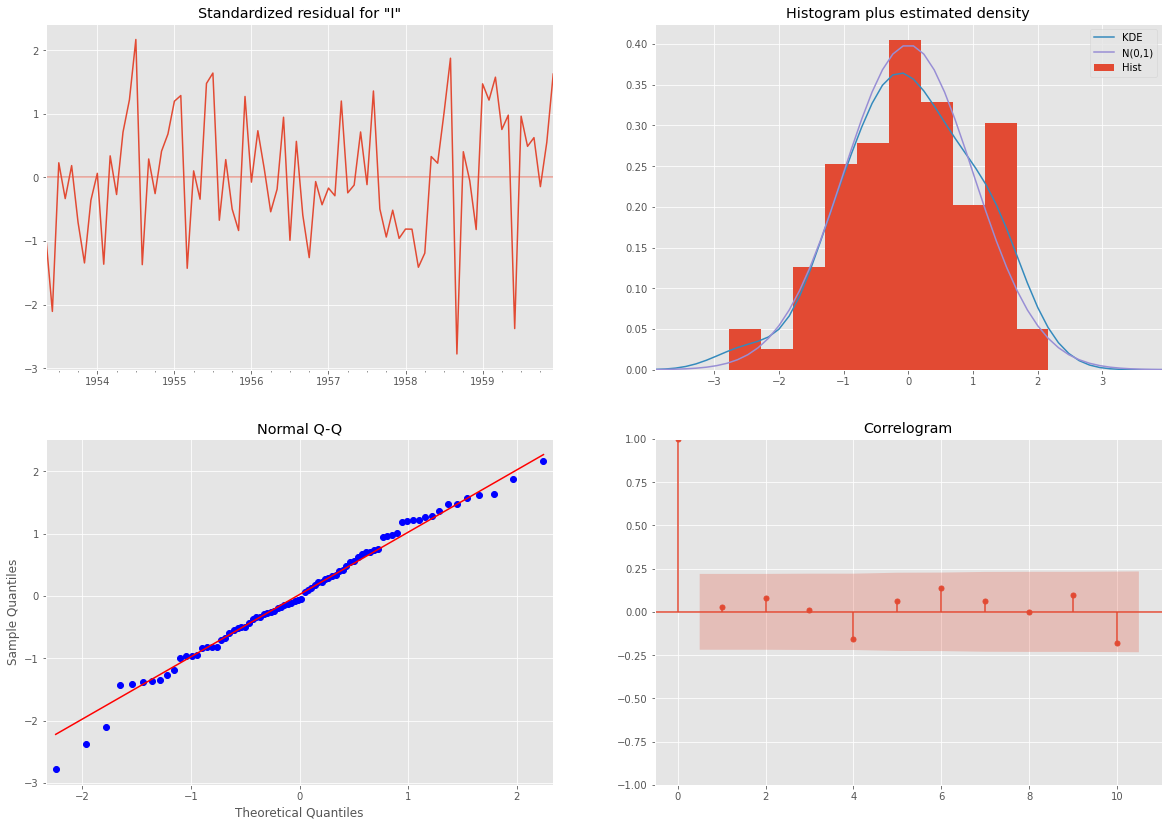

In [8]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

In the plots above, we can observe that the residuals are uncorrelated (bottom right plot) and do not exhibit any obvious seasonality (the top left plot). Also, the residuals and roughly normally distributed with zero mean (top right plot). The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) roghly follows the linear trend of samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

## Results
Now let's create some predictions. We will use three methods:

1) In sample prediction with 1-step ahead forecasting of the last year (1959). In this case the model is used to predict data that the model was built on. 1-step ahead forecasting implies that each forecasted point is used to predict the following one.

In [9]:
pred0 = results.get_prediction(start='1958-01-01', dynamic=False)
pred0_ci = pred0.conf_int()

2) In sample prediction with dynamic forecasting of the last year (1959). Again, the model is used to predict data that the model was built on.

In [10]:
pred1 = results.get_prediction(start='1958-01-01', dynamic=True)
pred1_ci = pred1.conf_int()

3) "True" forecasting of out of sample data. In this case the model is asked to predict data it has not seen before.

In [11]:
pred2 = results.get_forecast('1962-12-01')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['1960-01-01':'1960-12-01'])

1960-01-01    419.495063
1960-02-01    397.833995
1960-03-01    460.859198
1960-04-01    449.451918
1960-05-01    474.556382
1960-06-01    537.849752
1960-07-01    614.886498
1960-08-01    628.211147
1960-09-01    519.337140
1960-10-01    462.255011
1960-11-01    412.164239
1960-12-01    452.665034
Freq: MS, Name: predicted_mean, dtype: float64


Let's plot all this

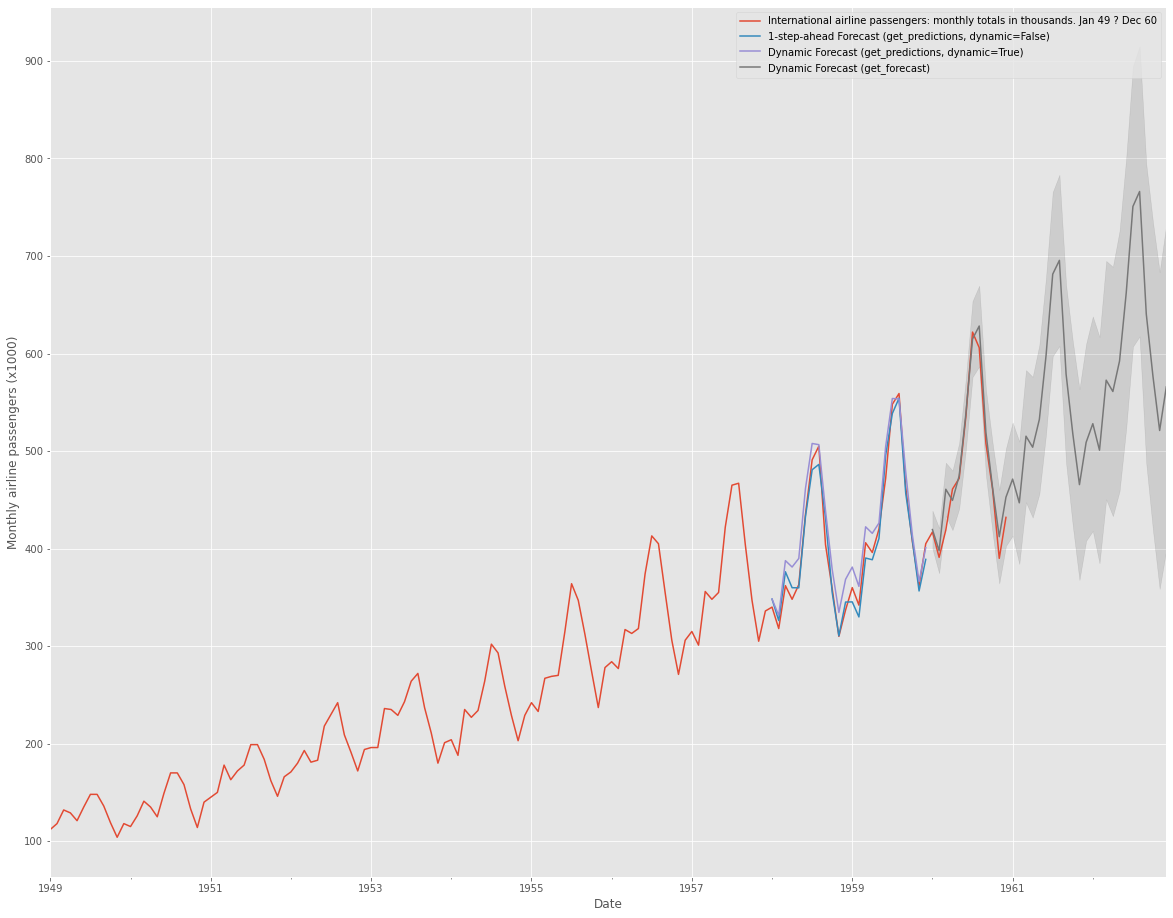

In [12]:
ax = data.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()
plt.show()

Looking at the figure, the model seems to do a pretty good job at modeling the time series. The blue and purple lines are, as expected, very close to the red ground truth. What is more interesting is the gray line, the out of sample predinction. For such a simple time series, the ARIMA model is able to forecast the 1960 values accurately.

In order to quantify the accuracy of the prediction for 1960, we can compute metrics such as Mean Absolute Error, Mean Squared Error, or Root Mean Squared Error. These are all absolute metrics, are therefore scale-dependent. While they are useful, and widely used to compare different methods on a same dataset, here it would be more useful to express the error relatively to the magnitude of the time series we are trying to predict. One commonly-used percentage error measure is the Mean Absolute Percentage Error (MAPE). It has some drawbacks in special cases (notably, it can lead to division by zero) and improved measures have been proposed, see e.g. https://www.otexts.org/fpp/2/5 for a nice overview. However, for this example we'll stick with MAPE.

In [13]:
prediction = pred2.predicted_mean['1960-01-01':'1960-12-01'].values
# flatten nested list
truth = list(itertools.chain.from_iterable(test_data.values))
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100

print('The Mean Absolute Percentage Error for the forecast of year 1960 is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the forecast of year 1960 is 2.81%


In [14]:
prediction

array([419.49506277, 397.83399515, 460.85919818, 449.45191843,
       474.55638215, 537.84975197, 614.88649839, 628.21114684,
       519.33714031, 462.25501076, 412.16423879, 452.66503412])

In [15]:
truth

[417, 391, 419, 461, 472, 535, 622, 606, 508, 461, 390, 432]